In [10]:
import os

import numpy as np
import pickle

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from utils import STIM_INFO_PATH, COCO_IMAGES_DIR, STIMULI_IDS_PATH
from data import get_fmri_data_paths, get_latent_features, LatentFeatsConfig
from eval import get_distance_matrix, dist_mat_to_pairwise_acc
from feature_extraction.feat_extraction_utils import CoCoDataset
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import trange
import nibabel

# Nearest Neighbors of test images

In [14]:
from utils import FMRI_DATA_DIR

SUBJECT = 'sub-01'
MODEL = "imagebind"
STIM_TYPE = 'image'
BETAS_DIR = os.path.join(FMRI_DATA_DIR, 'betas')
train_paths, stim_ids, stim_types = get_fmri_data_paths(BETAS_DIR, SUBJECT, "train_image")

feats_config = LatentFeatsConfig(
    MODEL, 'avg', 'avg', 'vision_features_cls','lang_features_cls',
)
latents = get_latent_features(feats_config,                                SUBJECT,                                "train"                                )
train_paths = np.array(train_paths)[stim_types == STIM_TYPE]



Selected features for imagebind: avg avg vision_features_cls lang_features_cls


In [15]:
train_fmri_betas = []
for idx in trange(len(train_paths), desc="loading fmri data"):
    sample = nibabel.load(train_paths[idx])
    sample = sample.get_fdata().astype('float32').reshape(-1)
    train_fmri_betas.append(sample)

train_fmri_betas = np.array(train_fmri_betas)


loading fmri data:   0%|          | 0/4897 [00:00<?, ?it/s]


FileNotFoundError: No such file or no access: '/home/mitja/data/multimodal_decoding/fmri/betas/sub-01/betas_train_image/beta_000071.nii'

In [6]:
test_paths, test_stim_ids, test_stim_types = get_fmri_data_paths(BETAS_DIR, SUBJECT, "test")
test_paths = np.array(test_paths)[test_stim_types == STIM_TYPE]
test_stim_ids = test_stim_ids[test_stim_types == STIM_TYPE]

In [7]:
test_fmri_betas = []
for idx in trange(len(test_paths), desc="loading fmri data"):
    sample = nibabel.load(test_paths[idx])
    sample = sample.get_fdata().astype('float32').reshape(-1)
    test_fmri_betas.append(sample)

test_fmri_betas = np.array(test_fmri_betas)


loading fmri data: 0it [00:00, ?it/s]


In [8]:
scaler = StandardScaler()
scaler.fit(train_fmri_betas)

train_fmri_betas_standardized = scaler.transform(train_fmri_betas)

# test_scaler = StandardScaler()
# test_scaler.fit(test_fmri_betas)
test_fmri_betas_standardized = scaler.transform(test_fmri_betas)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Train and test betas are not at the same scale

In [9]:
# df = pd.DataFrame([{'split': 'train', 'beta': beta} for beta in train_fmri_betas[:100].flatten()] + [{'split': 'test', 'beta': beta} for beta in test_fmri_betas.flatten()])
num_train_samples = 70
train_indices = np.random.choice(range(len(train_fmri_betas)), num_train_samples)
X = np.concatenate((train_fmri_betas[train_indices].flatten(), test_fmri_betas.flatten()))
hue = ['train'] * train_fmri_betas[train_indices].size + ['test'] * test_fmri_betas.size
plt.figure(figsize=(20,10))
sns.histplot(x=X, hue=hue, binwidth=3)
plt.ylim(0, 100000)
plt.xlim(-1000, 1000)
plt.title("unstandardized")

ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
num_train_samples = 70
train_indices = np.random.choice(range(len(train_fmri_betas_standardized)), num_train_samples)
X = np.concatenate((train_fmri_betas_standardized[train_indices].flatten(), test_fmri_betas_standardized.flatten()))
hue = ['train'] * train_fmri_betas_standardized[train_indices].size + ['test'] * test_fmri_betas_standardized.size
plt.figure(figsize=(20,10))
sns.histplot(x=X, hue=hue, binwidth=0.1)
plt.ylim(0, 1000000)
plt.xlim(-4, 4)
plt.title("standardized")

In [46]:
# print(len(train_fmri_betas))
# train_fmri_betas[:, 20000:20020].max(axis=0).mean()
# train_fmri_betas.max(axis=0).mean()


In [ ]:
# train_test = np.concatenate((test_fmri_betas, train_fmri_betas))
# pca = PCA(n_components=100)
# X_embedded_pca = pca.fit_transform(train_test)



In [ ]:
# standardize with global mean/std instead of feature-wise

new = (test_fmri_betas - test_fmri_betas.mean()) / test_fmri_betas.std()


print(new.mean(axis=1).mean())
print(new.std(axis=1).mean())

In [ ]:
means = train_fmri_betas.mean(axis=1)


In [ ]:
# means = np.array(means)
# stds = np.array(stds)
# print(means.shape)
# test_fmri_betas_standardized = (test_fmri_betas - means) / stds

In [ ]:
print(scaler.mean_[:10])
print(test_scaler.mean_[:10])


In [ ]:
# train_fmri_betas.shape
scaler = StandardScaler()
scaler.fit(train_fmri_betas)
train_fmri_betas_standardized = scaler.transform(train_fmri_betas)


test_scaler = StandardScaler()
test_scaler.fit(test_fmri_betas)
test_fmri_betas_standardized = test_scaler.transform(test_fmri_betas)

In [ ]:
# TFCE
TRAIN_SAMPLES = 1000
train_fmri_betas_subset = train_fmri_betas_standardized[np.random.choice(range(len(train_fmri_betas_standardized)), size=TRAIN_SAMPLES, replace=False)]
train_test = np.concatenate((test_fmri_betas_standardized, train_fmri_betas_subset))
tsne = TSNE(n_components=2, learning_rate='auto', verbose=2, n_jobs=10, n_iter=1000)
X_embedded = tsne.fit_transform(train_test)

print(X_embedded.shape)
assert X_embedded.shape[1] == 2
train_hues = ['train' for i in range(len(train_fmri_betas_subset))]
hue = ['test'] * len(test_fmri_betas) + train_hues
alpha = [1] * len(test_fmri_betas) + [0.3] * len(train_fmri_betas_subset)

plt.figure(figsize=(20, 12))
sns.scatterplot(
    x = X_embedded[:, 0], y = X_embedded[:, 1],
    hue = hue,
    legend = "full",
    alpha = alpha
)


In [15]:
# pca = PCA(n_components=2)
# X_embedded_pca = pca.fit_transform(train_test)

# train_hues = ['g' for i in range(len(train_fmri_betas))] #if i in outliers else 'b'
# hue = ['r'] * len(test_fmri_betas) + train_hues
# alpha = [1] * len(test_fmri_betas) + [0.1] * len(train_fmri_betas)
# 
# plt.figure(figsize=(20, 12))
# sns.scatterplot(
#     x = X_embedded_pca[:, 0], y = X_embedded_pca[:, 1],
#     hue = hue,
#     # palette = sns.color_palette("hls", 10),
#     legend = "full",
#     alpha = alpha
# )

In [16]:
# X_embedded_train = X_embedded[len(test_fmri_betas):]
# outlier_thresh = 25
# outliers = np.argwhere((X_embedded_train[:,0] > outlier_thresh) | (X_embedded_train[:,0] < -outlier_thresh) | (X_embedded_train[:,1] < -outlier_thresh) | (X_embedded_train[:,1] > outlier_thresh)) 
# outliers = outliers.flatten()
# len(outliers)
# pickle.dump(outliers, open('outliers.p', 'wb'))

In [17]:

# targets = pickle.load(open('/home/mitja/Downloads/targets.p', 'rb'))[test_stim_types == STIM_TYPE]
# preds = pickle.load(open('/home/mitja/Downloads/preds.p', 'rb'))[test_stim_types == STIM_TYPE]
# print(targets.shape)
# print(preds.shape)
train_preds = pickle.load(open('/home/mitja/aireps/multimodal_decoding/sub-01_train_preds.p', 'rb'))#[test_stim_types == STIM_TYPE]
train_preds.shape

FileNotFoundError: [Errno 2] No such file or directory: '/home/mitja/aireps/multimodal_decoding/sub-01_train_preds.p'

In [18]:
#preds_old = preds

In [19]:
results = pickle.load(open(
    '/home/mitja/data/multimodal_decoding/whole_brain_decoding/train_image/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls/results.p',
    'rb'))
preds = results['predictions'][test_stim_types == STIM_TYPE]
targets = results['latents'][test_stim_types == STIM_TYPE]

print(targets.shape)
print(preds.shape)



FileNotFoundError: [Errno 2] No such file or directory: '/home/mitja/data/multimodal_decoding/whole_brain_decoding/train_image/sub-01/imagebind_avg_test_avg_vision_features_cls_lang_features_cls/results.p'

In [20]:
# train_test_preds = np.concatenate((preds, train_preds))

# preds_standardize = Standardize(preds.mean(axis=0), preds.std(axis=0))
train_scaler = StandardScaler()
train_scaler.fit(train_preds)
train_preds_standardized = train_scaler.transform(train_preds)

test_scaler = StandardScaler()
test_scaler.fit(preds)
preds_standardized = test_scaler.transform(preds)
# preds_standardized = preds_standardize(preds)
# train_preds_standardized = preds_standardize(train_preds)


NameError: name 'train_preds' is not defined

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5068 samples in 0.003s...
[t-SNE] Computed neighbors for 5068 samples in 1.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5068
[t-SNE] Computed conditional probabilities for sample 2000 / 5068
[t-SNE] Computed conditional probabilities for sample 3000 / 5068
[t-SNE] Computed conditional probabilities for sample 4000 / 5068
[t-SNE] Computed conditional probabilities for sample 5000 / 5068
[t-SNE] Computed conditional probabilities for sample 5068 / 5068
[t-SNE] Mean sigma: 0.220175
[t-SNE] Computed conditional probabilities in 0.079s
[t-SNE] Iteration 50: error = 88.2844467, gradient norm = 0.0163546 (50 iterations in 0.813s)
[t-SNE] Iteration 100: error = 85.5925598, gradient norm = 0.0027027 (50 iterations in 0.847s)
[t-SNE] Iteration 150: error = 85.1005096, gradient norm = 0.0003969 (50 iterations in 0.734s)
[t-SNE] Iteration 200: error = 85.0825806, gradient norm = 0.0000531 (50 iterations in 0.743s)
[t

<Axes: >

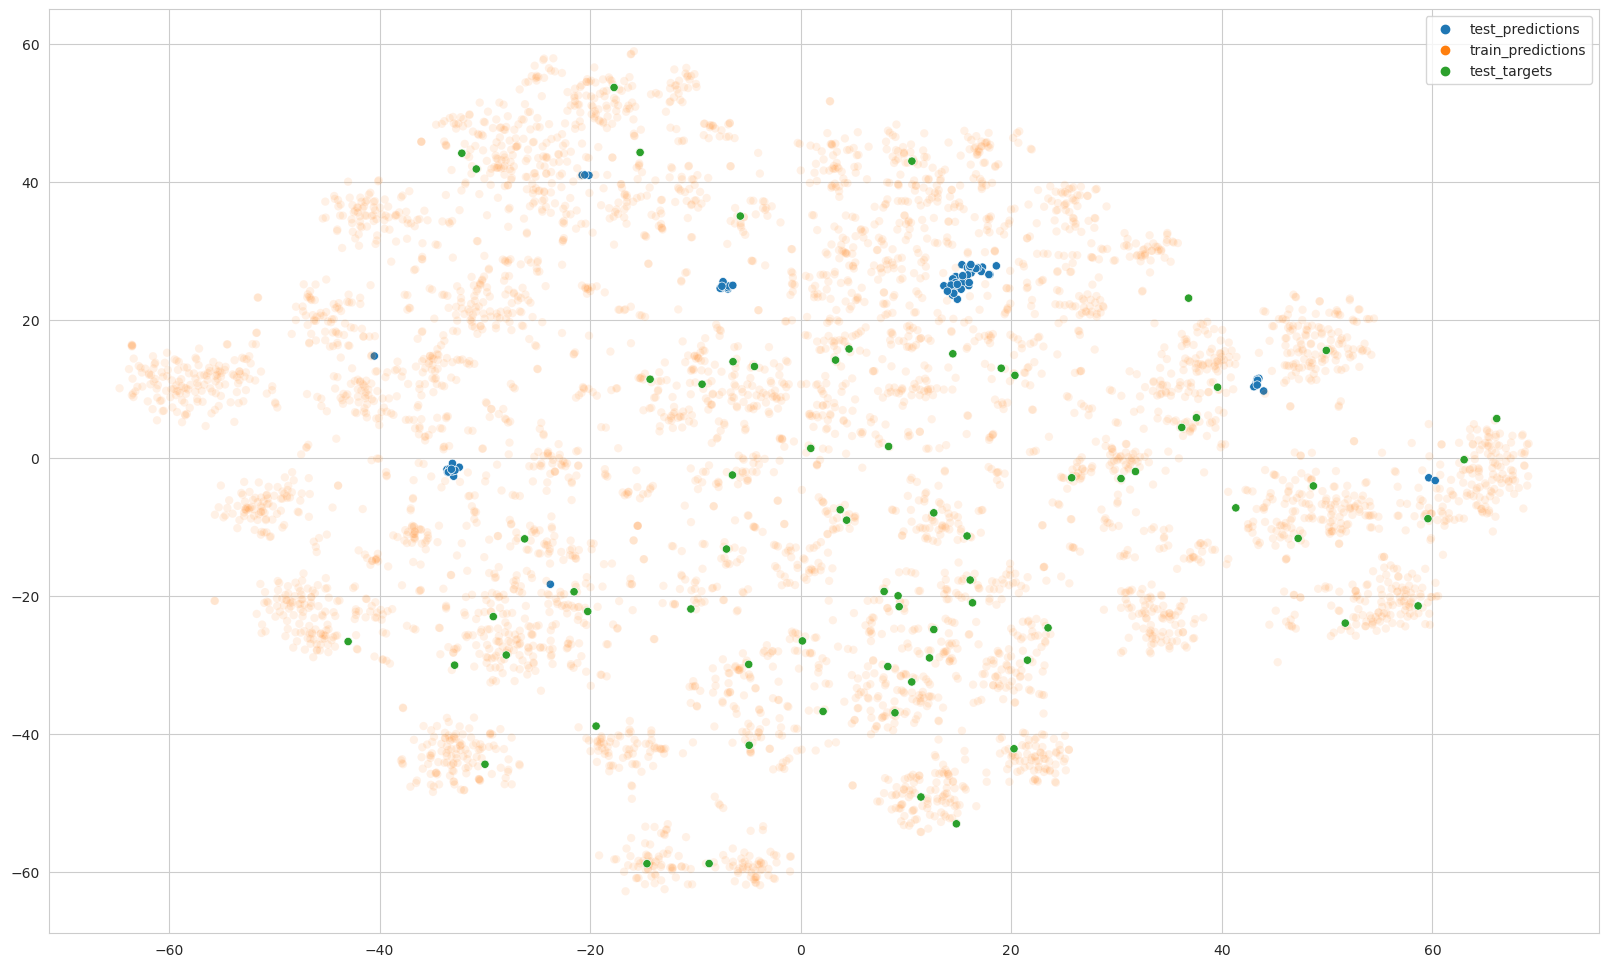

In [22]:
concatenated = np.concatenate((preds, train_preds, targets))
tsne = TSNE(n_components=2, learning_rate='auto', verbose=2, n_jobs=10, metric='cosine')#, metric='cosine'
preds_embedded = tsne.fit_transform(concatenated)

hue = ['test_predictions'] * len(preds) + ['train_predictions' for i in range(len(train_preds))]  + ['test_targets'] * len(targets)  
alpha = [1] * len(preds) + [0.1] * len(train_preds) + [1] * len(targets)

plt.figure(figsize=(20, 12))
sns.scatterplot(
    x = preds_embedded[:, 0], y = preds_embedded[:, 1],
    hue = hue,
    # palette = sns.color_palette("hls", 10),
    legend = "full",
    alpha = alpha
)

In [13]:
concatenated = np.concatenate((preds_standardized, train_preds, targets, latents))
tsne = TSNE(n_components=2, learning_rate='auto', verbose=2, n_jobs=10, metric='cosine')#, metric='cosine'
preds_embedded = tsne.fit_transform(concatenated)

hue = ['test_predictions'] * len(preds) + ['train_predictions' for i in range(len(train_preds))]  + ['test_targets'] * len(targets)  + ['train_targets'] * len(latents)
alpha = [1] * len(preds) + [0.1] * len(train_preds) + [1] * len(targets) + [0.1] * len(latents)

plt.figure(figsize=(20, 12))
sns.scatterplot(
    x = preds_embedded[:, 0], y = preds_embedded[:, 1],
    hue = hue,
    # palette = sns.color_palette("hls", 10),
    legend = "full",
    alpha = alpha
)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 50 and the array at index 3 has size 1024

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 540 samples in 0.001s...
[t-SNE] Computed neighbors for 540 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 540 / 540
[t-SNE] Mean sigma: 0.381501
[t-SNE] Computed conditional probabilities in 0.011s
[t-SNE] Iteration 50: error = 63.4391365, gradient norm = 0.0000027 (50 iterations in 0.129s)
[t-SNE] Iteration 100: error = 63.4368744, gradient norm = 0.0000000 (50 iterations in 0.055s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 63.436874
[t-SNE] Iteration 150: error = 1.0151342, gradient norm = 0.0129663 (50 iterations in 0.084s)
[t-SNE] Iteration 200: error = 0.8772718, gradient norm = 0.0092984 (50 iterations in 0.050s)
[t-SNE] Iteration 250: error = 0.8290283, gradient norm = 0.0074079 (50 iterations in 0.046s)
[t-SNE] Iteration 300: error = 0.8101090, gradient norm = 0.0049913 (50 iterations in 0.049s)
[t-SNE] Iterati

<Axes: >

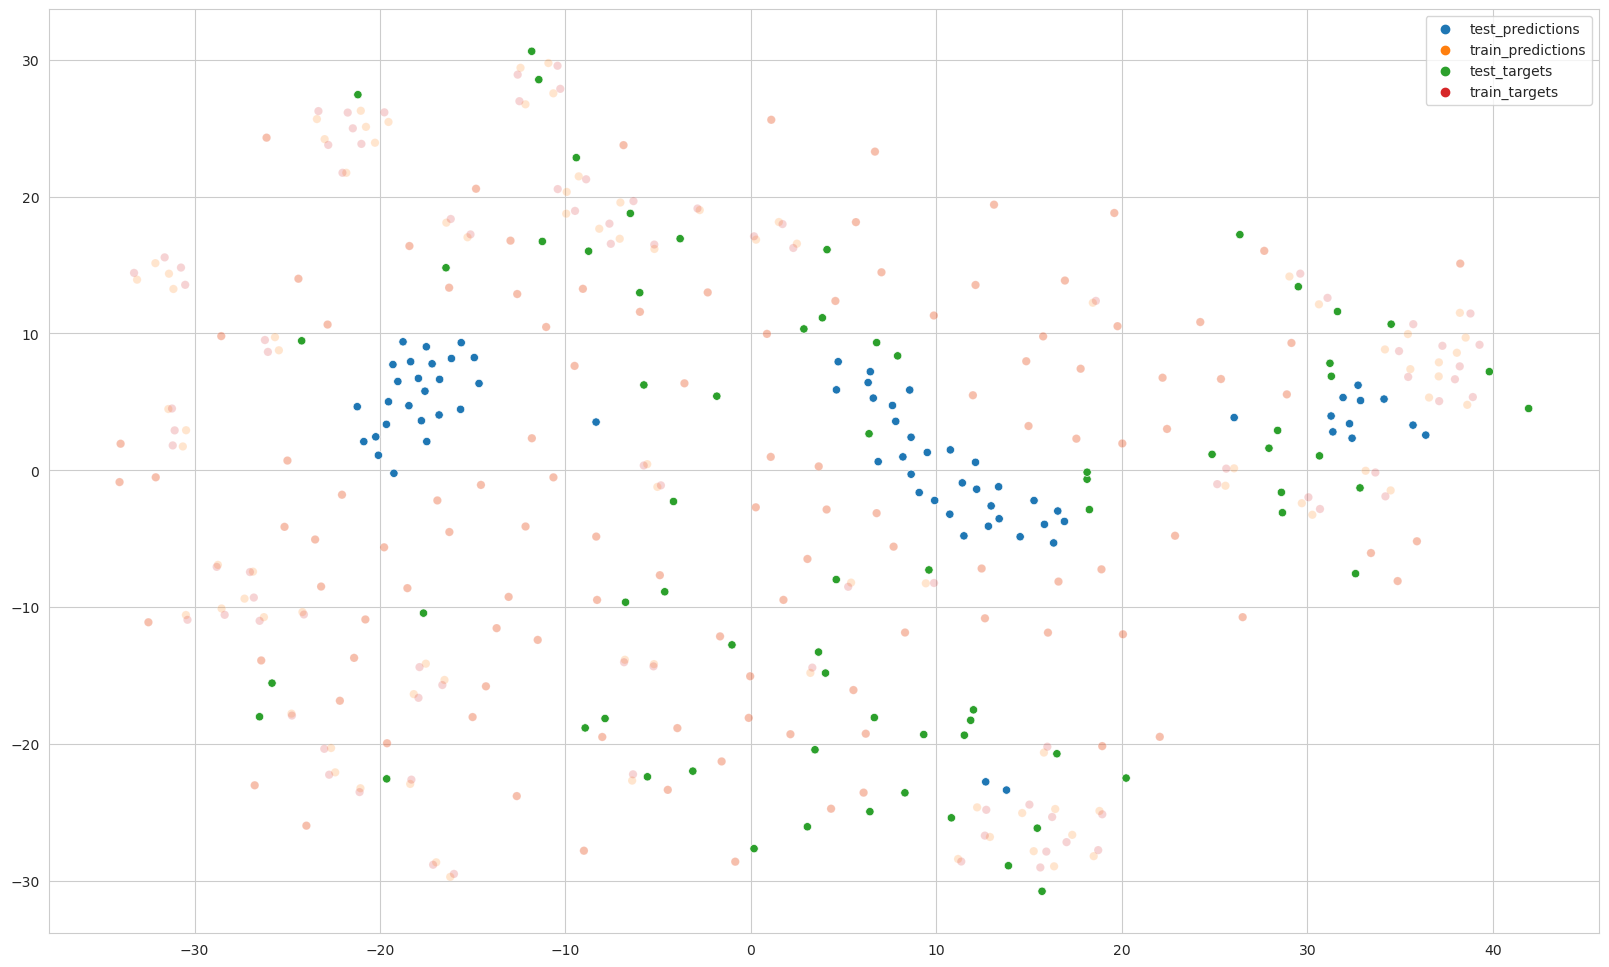

In [134]:
train_preds_sub = train_preds[:200]
latents_sub = latents[:200]
concatenated = np.concatenate((preds_standardized, train_preds_sub, targets, latents_sub))
tsne = TSNE(n_components=2, learning_rate='auto', verbose=2, n_jobs=10, metric='cosine')#, metric='cosine'
preds_embedded = tsne.fit_transform(concatenated)

hue = ['test_predictions'] * len(preds) + ['train_predictions' for i in range(len(train_preds_sub))]  + ['test_targets'] * len(targets)  + ['train_targets'] * len(latents_sub)
alpha = [1] * len(preds) + [0.2] * len(train_preds_sub) + [1] * len(targets) + [0.2] * len(latents_sub)

plt.figure(figsize=(20, 12))
sns.scatterplot(
    x = preds_embedded[:, 0], y = preds_embedded[:, 1],
    hue = hue,
    # palette = sns.color_palette("hls", 10),
    legend = "full",
    alpha = alpha
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.429885
[t-SNE] Computed conditional probabilities in 0.018s
[t-SNE] Iteration 50: error = 60.4871063, gradient norm = 0.0000028 (50 iterations in 0.102s)
[t-SNE] Iteration 100: error = 60.4866486, gradient norm = 0.0000000 (50 iterations in 0.037s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 60.486649
[t-SNE] Iteration 150: error = 0.7762377, gradient norm = 0.0093109 (50 iterations in 0.035s)
[t-SNE] Iteration 200: error = 0.6801535, gradient norm = 0.0072824 (50 iterations in 0.053s)
[t-SNE] Iteration 250: error = 0.6534820, gradient norm = 0.0041553 (50 iterations in 0.045s)
[t-SNE] Iteration 300: error = 0.6460775, gradient norm = 0.0030294 (50 iterations in 0.040s)
[t-SNE] Iterati

<Axes: >

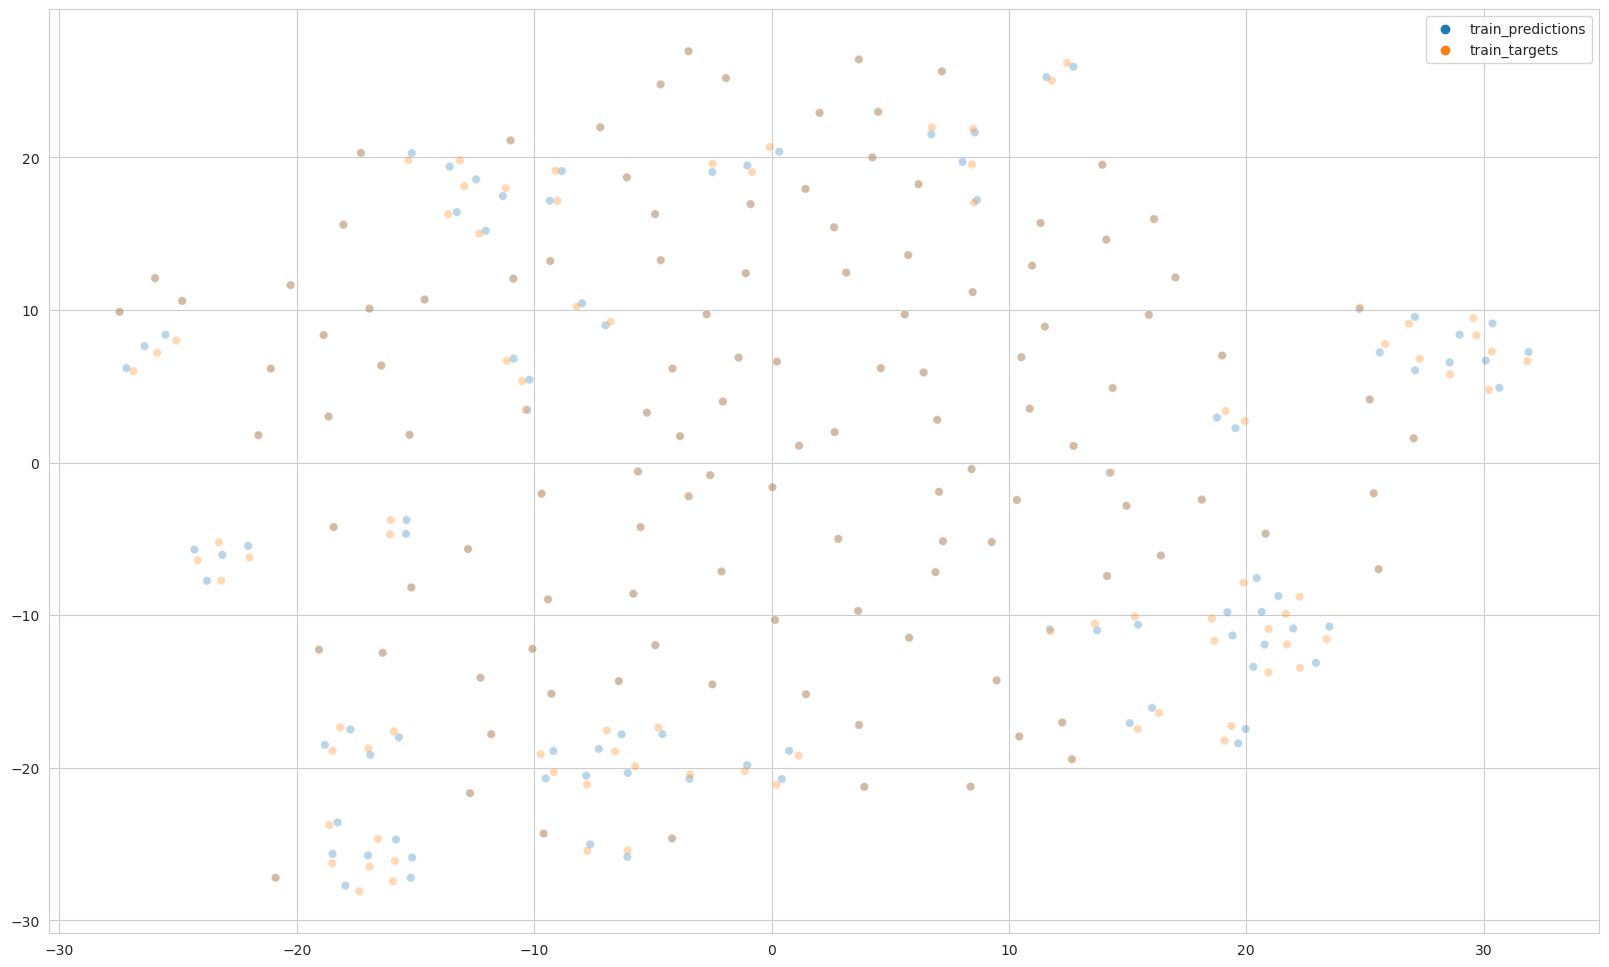

In [135]:
train_preds_sub = train_preds[:200]
latents_sub = latents[:200]
concatenated = np.concatenate((train_preds_sub, latents_sub))
tsne = TSNE(n_components=2, learning_rate='auto', verbose=2, n_jobs=10, metric='cosine')#, metric='cosine'
preds_embedded = tsne.fit_transform(concatenated)
hue = ['train_predictions'] * len(train_preds_sub)  + ['train_targets'] * len(latents_sub)# 
alpha = [0.3] * len(train_preds_sub) + [0.3] * len(latents_sub)
# preds_embedded[len(train_preds)+100:] = 0
print(preds_embedded.shape)
print(len(hue))
plt.figure(figsize=(20, 12))
sns.scatterplot(
    x = preds_embedded[:, 0],
    y = preds_embedded[:, 1],
    hue = hue,
    alpha = alpha
)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 140 samples in 0.001s...
[t-SNE] Computed neighbors for 140 samples in 0.086s...
[t-SNE] Computed conditional probabilities for sample 140 / 140
[t-SNE] Mean sigma: 0.382556
[t-SNE] Computed conditional probabilities in 0.013s
[t-SNE] Iteration 50: error = 53.8066139, gradient norm = 0.4401832 (50 iterations in 0.090s)
[t-SNE] Iteration 100: error = 57.3659592, gradient norm = 0.3154992 (50 iterations in 0.042s)
[t-SNE] Iteration 150: error = 54.4088974, gradient norm = 0.4263150 (50 iterations in 0.040s)
[t-SNE] Iteration 200: error = 55.6243935, gradient norm = 0.4174927 (50 iterations in 0.039s)
[t-SNE] Iteration 250: error = 57.0309334, gradient norm = 0.3896331 (50 iterations in 0.036s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.030933
[t-SNE] Iteration 300: error = 0.5942178, gradient norm = 0.0073436 (50 iterations in 0.040s)
[t-SNE] Iteration 350: error = 0.5492375, gradient norm = 0.0030631 (

<Axes: >

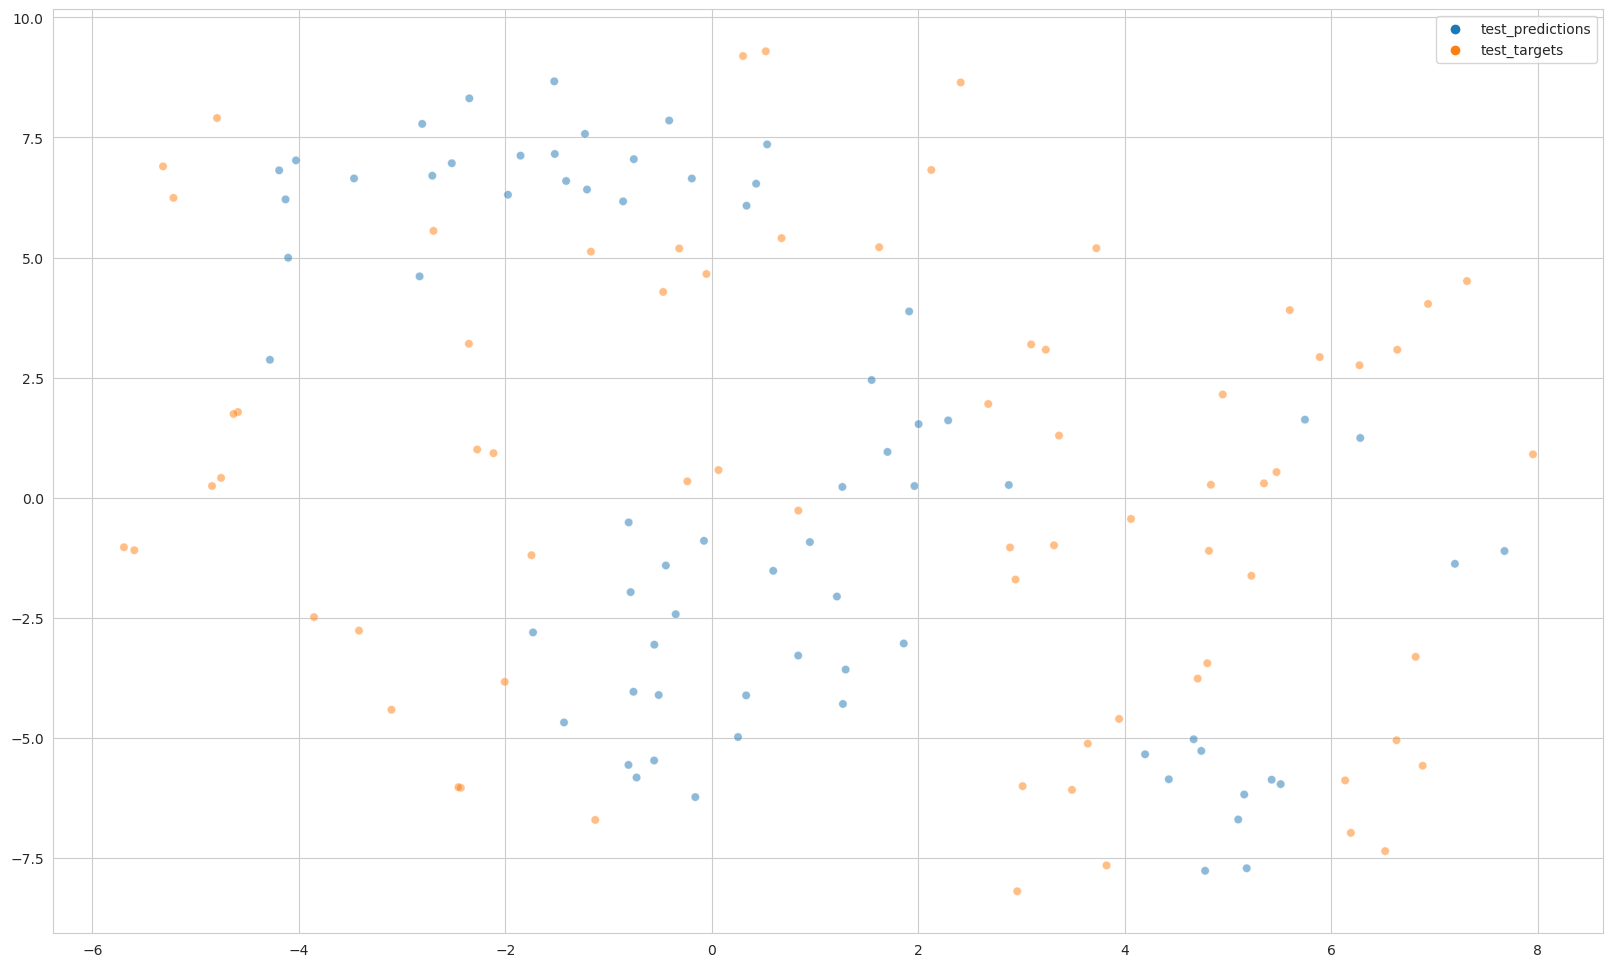

In [140]:
concatenated = np.concatenate((preds_standardized, targets))
tsne = TSNE(n_components=2, learning_rate='auto', verbose=2, n_jobs=10, metric='cosine')#, metric='cosine'
preds_embedded = tsne.fit_transform(concatenated)
hue = ['test_predictions'] * len(preds)  + ['test_targets'] * len(targets)# 
alpha = [0.5] * len(preds) + [0.5] * len(targets)
# preds_embedded[len(train_preds)+100:] = 0
print(preds_embedded.shape)
print(len(hue))
plt.figure(figsize=(20, 12))
sns.scatterplot(
    x = preds_embedded[:, 0],
    y = preds_embedded[:, 1],
    hue = hue,
    alpha = alpha
)

## Nearest neighbors

In [25]:
def display_stimuli(coco_ids):
    for coco_id in coco_ids:
        print(coco_ds.captions[coco_id], end="\n")


coco_ds = CoCoDataset(COCO_IMAGES_DIR, STIM_INFO_PATH, STIMULI_IDS_PATH, 'caption')

In [28]:
NUM_SAMPLES = 5
N_NEIGHBORS = 5
# training_mode = 'modality-agnostic'
training_mode = 'images'

print(f"fMRI stimulus modality: {STIM_TYPE}")

candidate_set_latents = targets
candidate_set_latents_ids = test_stim_ids

test_predictions = preds #
preds_standardize = Standardize(test_predictions.mean(axis=0), test_predictions.std(axis=0))
test_predictions = preds_standardize(test_predictions)

# candidate_set_latents = np.concatenate((latents, targets))
# candidate_set_latents_ids = np.concatenate((stim_ids, test_stim_ids))

dist_mat = get_distance_matrix(test_predictions, candidate_set_latents)
acc = dist_mat_to_pairwise_acc(dist_mat)
print(f"Pairwise acc: {acc:.2f}")
np.random.seed(7)
sampled_ids = np.random.choice(range(len(test_stim_ids)), NUM_SAMPLES, replace=False)
test_stimulus_ids = test_stim_ids[sampled_ids]
dist_mat = dist_mat[sampled_ids]

for test_stimulus_id, nneighbors_row in zip(test_stimulus_ids, dist_mat):
    print(f"test stimulus: {test_stimulus_id}")
    display_stimuli([test_stimulus_id])
    # if STIM_TYPE == CAPTION:
    #     print(coco_ds.get_stimuli_by_coco_id(test_stimulus_id)[1])
    # else:
    #     img = coco_ds.get_img_by_coco_id(test_stimulus_id)
    #     new_width  = 400
    #     new_height = round(new_width * img.height / img.width)
    #     display(img.resize((new_width, new_height)))
    target_location = np.argwhere(candidate_set_latents_ids == test_stimulus_id)[0][0]
    nneighbors_ids = candidate_set_latents_ids[np.argsort(nneighbors_row)]
    rank = np.argwhere(nneighbors_ids == test_stimulus_id)[0][0]
    # all_ranks.append(rank)
    # display(f"distance to target: {nneighbors_row[target_location]:.3f} | rank: {rank} of {len(nneighbors_row)}")
    # display(f"nearest neighbors distances: {np.sort(nneighbors_row)[:10]}")
    print("nearest neighbors: ")

    display_stimuli(nneighbors_ids[:N_NEIGHBORS])
    print("\n")

# print(f"mean rank: {np.mean(all_ranks)}")


fMRI stimulus modality: image
Pairwise acc: 0.93
test stimulus: 163240
A train coming up the tracks through trees
nearest neighbors: 
a jet plane is parked out on a runway
An old school bus is parked in a field
A train coming up the tracks through trees
A dump truck sits by a stop sign
A double decker bus is in the street


test stimulus: 16764
A small dog standing inside a car
nearest neighbors: 
A young boy holding onto a parking meter
a woman holds a bundle of bananas
These two dogs sit on a bench together
a cat sitting in a bathroom sink
A cat sits on top of a desk


test stimulus: 450719
A giraffe drinking water from a man-made pond
nearest neighbors: 
A teenager surfing a wave in an ocean
A man that is on a skateboard on a ledge
A snow boarder is in the air over the snow
a cat sitting in a bathroom sink
a bowl of food in an open microwave


test stimulus: 195406
The teddy bear has a big bright red bow
nearest neighbors: 
a cat sitting in a bathroom sink
a close up of a piece of c